# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [107]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts)
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [108]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import cdist

class Clustering(BaseEstimator, ClusterMixin):
    """
    DBSCAN
    """
    
    def __init__(self, eps, min_pts):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.eps = eps
        self.min_pts = min_pts
        self.clusters = np.array([])
        return
        
    def fit(self, x):
        """
        ПРИГОТОВЬТЕСЬ В ПОЛНОЙ КЛАСТЕРИЗАЦИИ
        """
        self.clusters = np.full(len(x), -1)
        self.X = x
        self.__dbscan()
        return self
    
    def predict(self, x):
        """
        Отдаем наши классы
        """
        return self.clusters
    
    def fit_predict(self, x):
        self.fit(x)
        return self.predict(x)
    
    def __dbscan(self):
        """
        Реализаци DBSCAN
        """
        # Создаем массив индексов точек
        self.points_indexes = np.arange(0, len(self.X) - 1)
        
        while len(self.points_indexes) != 0:
            # Получаем случайный индекс индекса точки
            rand_idx = np.random.randint(0, len(self.points_indexes))
            # Получаем индекс точки
            point_idx = self.points_indexes[rand_idx]
            # Удаляем индекс точки из общего набора, таким образом в массиве индексов точек остаются только не обработанные
            self.points_indexes = np.delete(self.points_indexes, rand_idx, axis=0) 
            # Получаем индексы соседей выбранной точки
            nbrs_idx = self.__neighbours_idx(point_idx)
            if len(nbrs_idx) >= self.min_pts:
                # Создаем новый кластер
                new_cluster = self.clusters.max() + 1
                # Добавляем нашу точку в кластер
                self.clusters[point_idx] = new_cluster
                # Расширяем кластер
                self.__expand_cluster(nbrs_idx, new_cluster)
            
        
    def __expand_cluster(self, nbrs_idx, cluster):
        """
        Расширение кластера
        """
        while len(nbrs_idx) != 0 :
            rand_idx = np.random.randint(0, len(nbrs_idx))
            nbr_idx = nbrs_idx[rand_idx]
            if nbr_idx in self.points_indexes:
                # Удаляем индекс точки из общего набора
                self.points_indexes = np.delete(self.points_indexes, np.argwhere(self.points_indexes == nbr_idx))
                # Добавляем новых соседей, если их достаточно
                new_nbrs_idx = self.__neighbours_idx(nbr_idx)
                if len(new_nbrs_idx) >= self.min_pts:
                    nbrs_idx = np.unique(np.append(nbrs_idx, new_nbrs_idx))
            # Добавляем соседа в кластер, если он еще не в кластере
            if self.clusters[nbr_idx] == -1:
                self.clusters[nbr_idx] = cluster
                
            nbrs_idx = np.delete(nbrs_idx, rand_idx)
        
    def __neighbours_idx(self, point_idx):
        """
        Поиск соседей
        """
        # Считаем расстояние до каждой точки
        dist = cdist(np.array([self.X[point_idx]]), self.X)
        res = np.nonzero(dist[0] <= self.eps)
        return np.array(res)[0]

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

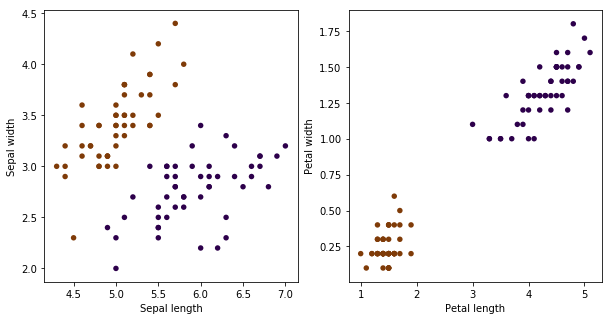

In [109]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [114]:
pred_iris = Clustering(1, 5).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

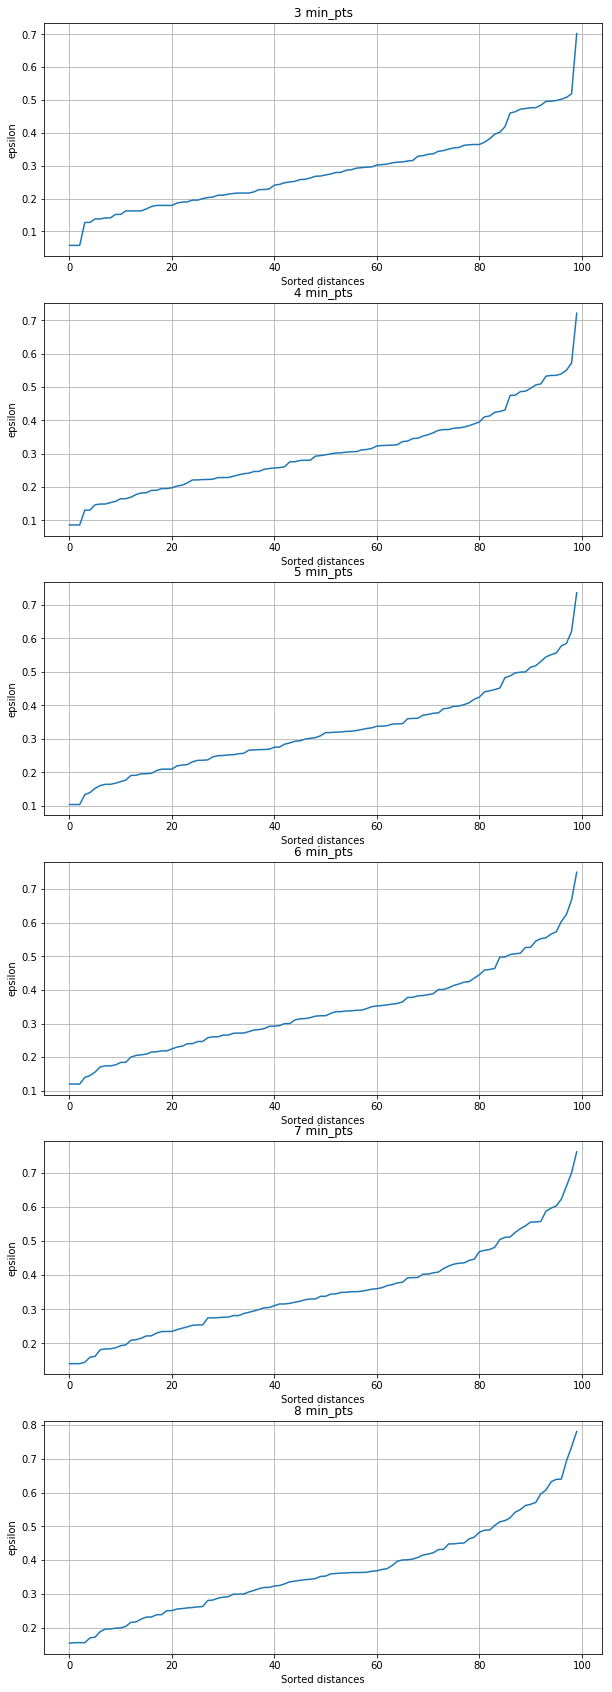

In [105]:
ks = range(3, 9)

pl.figure(figsize=(10, 30))

for num, k in enumerate(ks):
    criteria = np.zeros(len(x_iris))
    for i, x in enumerate(x_iris):
        dist = cdist([x], x_iris)
        dist.sort()
        criteria[i] = dist[0][1: 1 + k].sum() / k
    criteria.sort()
    pl.subplot(len(ks), 1, num + 1 )
    pl.plot(range(len(criteria)), criteria)
    pl.title("{} min_pts".format(k))
    pl.ylabel("epsilon")
    pl.xlabel("Sorted distances")
    pl.grid()



pl.show()

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

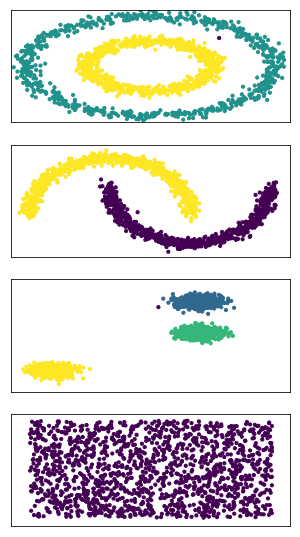

In [106]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    cls = DBSCAN(0.2, 5)
    y = cls.fit_predict(X)
    
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

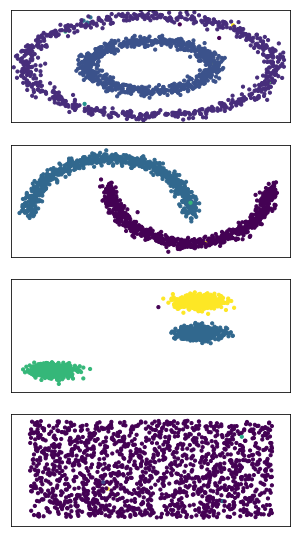

In [49]:
plt.figure(figsize=(2 + 3, 9.5))
data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    cls = Clustering(0.2, 5)
    y = cls.fit_predict(X)
    
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

pl.show()